# The TE/TM splitting in confined geometries

In this tutorial, we will learn how to use the sover to solve for multiple fields, then we will use some more advanced plotting possibilities to explore multiple fields.

Here, we will solve the Optical Schrödinger equation, taking into account some polarization splittings in different bases. In the circular polarization basis, the coupled equations writes:

$$\left[\alpha \Delta + V(\textbf{r}) \right] \psi_\pm + \left[\beta(\partial_x \mp i \partial_y)^2 +\gamma e^{\pm i\phi_0}\right]\psi_\mp = 0$$


With $\alpha = \hbar^2/2m$, $\beta$ a coefficient representing the strength of the TE/TM splitting ([ref](doi.org/10.1103/PhysRevB.59.5082)) and $\alpha, \phi_0$ the strength and direction of a linear birefringence. Let's explore these effects on the energy levels of a circular pillar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bloch_schrodinger.potential import Potential, create_parameter
from bloch_schrodinger.fdsolver import FDSolver

a1 = [2.1,0]
a2 = [0,2.1]

pillar = Potential(
    unitvecs=[a1,a2],
    resolution = (75,74), # slight anisotropy to prevent exact degeneracies, which numerical solvers don't like
    v0 = 600
)

pillar.circle(
    center=(0,0),
    radius = 1
)

# The radius will be changed by rescaling the energy*length² terms, in order to remove discretiation effects. This only works because only the scale of the potential changes
radius = create_parameter('r', np.linspace(1, 3, 7))

alpha = 1.2 / radius**2
beta = create_parameter('beta', np.linspace(-0.05, 0.05, 7)) / radius**2
gamma = create_parameter('gamma', np.linspace(-0.2, 0.2, 3))
# Let's take phi0 = 0 to reduce the parameter space

solv = FDSolver(
    potentials = [pillar, pillar], # We have two fields, each seing the same potential
    alphas = [alpha, alpha] # In the circular basis, both polarizations have the same mass term
)

# --- Adding coupling terms ---
# The TE/TM splittings and local coupling terms can be set with dedicated high level functions, 
# but it is also possible to use the lower level functions to set a coupling term, see the dedicated tutorial

solv.add_coupling_parameter('beta', beta) # The coupling parameters must be added by hand
solv.add_coupling_parameter('gamma', gamma)



solv.add_TETM(
    expr='beta', # The expression for the strength of the coupling term, is given as a string to be evaluated latter
    field1 = 0, # We need to tell which fields are the photonic ones, in case there is more than 2 fields
    field2 = 1
)

solv.add_on_site_coupling( # This function creates a local coupling term between fields
    expr='gamma',
    field1 = 0,
    field2 = 1
)

eigva, eigve = solv.solve(
    n_eigva=6, # Let's look at the s and p modes
    parallel=True,
    n_cores=-1
)

# Go chill for a few minutes

Performing 147 diagonalizations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 138 out of 147 | elapsed:  1.8min remaining:    7.1s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  1.9min finished


storing the results


100%|██████████| 147/147 [00:00<00:00, 456.39it/s]


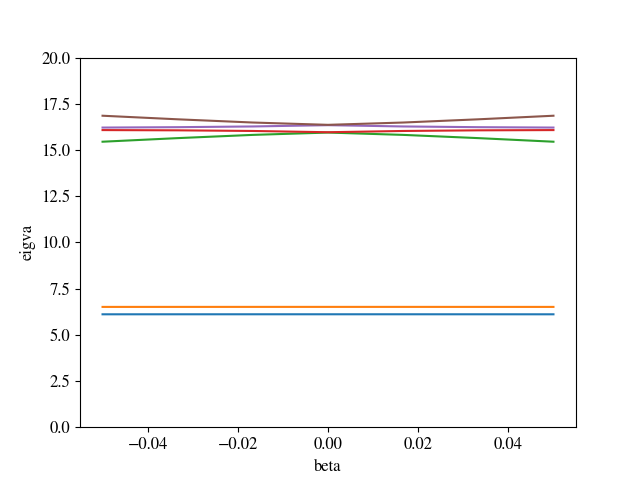

In [2]:
# don't forget the magic command to activate interactivity
%matplotlib widget
from bloch_schrodinger.plotting import plot_cuts
import cmcrameri.cm as cm

plot_cuts(eigva, "beta", ymin = 0, ymax = 20)
plt.show()

We can look at the polarization pattern of the modes, using the quiver mode of the 'plot_eigenvector' function.

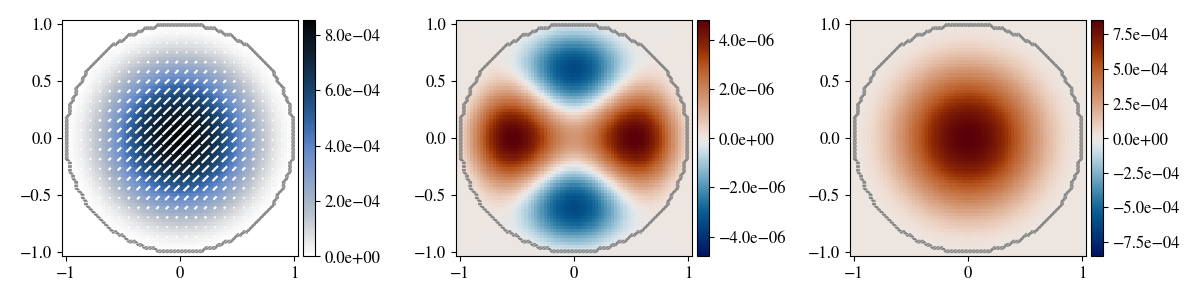

In [5]:
from bloch_schrodinger.plotting import plot_eigenvector, cmesh_tmpl, quiver_tmpl, contour_tmpl
from xarray.ufuncs import cos, sin, arctan2

S0 = abs(eigve.sel(field=0))**2 + abs(eigve.sel(field=1))**2
S1 = 2*(eigve.sel(field=1) * eigve.sel(field=0).conj()).real
S2 = -2*(eigve.sel(field=1) * eigve.sel(field=0).conj()).imag

# We are going to plot the polarization direction of the modes
polar_x = cos(arctan2(S2,S1)/2) * S0
polar_y = sin(arctan2(S2,S1)/2) * S0

# Let's create a specific template for stokes parameters
stokes_tmpl = cmesh_tmpl('real')
stokes_tmpl['fkwargs']['cmap'] = cm.vik

# We modify also the quiver template
quiv = quiver_tmpl()
quiv["fkwargs"]["scale"] = 1.5e-2 # Use this parameter to control the sizes of the arrows on the quiver plot
quiv["fkwargs"]["headwidth"] = 0 # we plot a direction, not a vector
quiv["fkwargs"]["headaxislength"] = 0 
quiv["fkwargs"]["headlength"] = 0
quiv["fkwargs"]['color'] = 'white'
quiv['density'] = 3

plot_eigenvector(
    plots = [[S0, S1, S2]],
    potentials=[[pillar, pillar, pillar]],
    templates=[[('amplitude', contour_tmpl(), quiv), stokes_tmpl, stokes_tmpl]],
    quivers=[[(polar_x, polar_y), None, None]]
)
plt.show()